In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from keras.callbacks import EarlyStopping
from matplotlib.colors import LogNorm
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.mixture import BayesianGaussianMixture
from tabulate import tabulate
import cv2 as cv
from google.colab.patches import cv2_imshow
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from scipy.stats import ortho_group
from scipy.spatial import procrustes
import os
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
path_covid = '/content/drive/MyDrive/AML/Covid19-dataset/train/Covid'
path_norm = '/content/drive/MyDrive/AML/Covid19-dataset/train/Normal'
path_viral= '/content/drive/MyDrive/AML/Covid19-dataset/train/Viral Pneumonia'

imgs_covid = sorted(os.listdir(path_covid))
imgs_norm = sorted(os.listdir(path_norm))
imgs_viral = sorted(os.listdir(path_viral))


img_covid=[]
y_covid =[]
for image in imgs_covid:
  img_covid.append(cv.imread(os.path.join(path_covid, image), cv.IMREAD_GRAYSCALE))
  y_covid.append(0)

y_norm =[]
img_norm = []
for image in imgs_norm:
  img_norm.append(cv.imread(os.path.join(path_norm, image), cv.IMREAD_GRAYSCALE))
  y_norm.append(1)

img_viral = []
y_viral =[]
for image in imgs_viral:
  img_viral.append(cv.imread(os.path.join(path_viral, image), cv.IMREAD_GRAYSCALE))
  y_viral.append(2)

In [3]:
# adding all imgs from three folders
imgs = imgs_covid +imgs_norm + imgs_viral

In [4]:
# adding all imgs from three folders and making three categories(Covid-19(0),Normal(1) and Viral Pneumonia(2))
img = img_covid + img_norm  + img_viral
category = y_covid + y_norm +y_viral

In [5]:
img_resized = []
for res_img in img:
  img_resized.append(cv.resize(res_img, (256, 256)))

# flatten
img_flat = []
for i in range(len(img_resized)):
  img_flat.append(np.ravel(img_resized[i]))
img_flat = np.array(img_flat)

# scaling
img_flat = img_flat/255.0

In [6]:
img_flat.shape

(251, 65536)

# 1:

In [7]:
st= time.time()
pca = PCA(n_components=0.95)
pca_reduced = pca.fit_transform(img_flat)
print(f'The number of components required to preserve 95 percent variance is {pca.n_components_}')

print(time.time() - st)

The number of components required to preserve 95 percent variance is 126
3.94494366645813


# 1: Solution
The number of components required to preserve 95 percent variance is 126.

# 2:


In [15]:
pca_reduced.shape

(251, 126)

In [16]:
# reconstruction
pca_recovered = pca.inverse_transform(pca_reduced)

In [17]:
pca_recovered.shape

(251, 65536)

Since the image is flattened we have to reshape it back to 256, 256 to plot them

In [18]:
# reshaping
pca_recovered = pca_recovered.reshape(pca_recovered.shape[0], 256, 256)

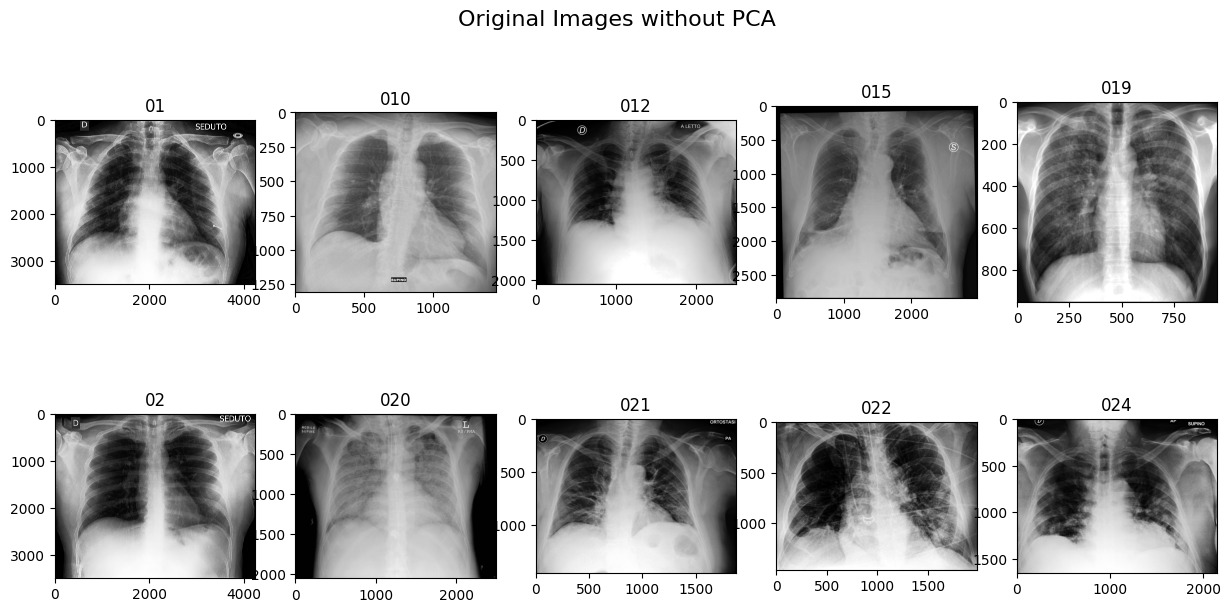

In [19]:
plt.figure(figsize=(15, 7))
plt.suptitle("Original Images without PCA", fontsize=16)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i], cmap='gray')
    if i < len(imgs):
        plt.title(imgs[i].removesuffix('.jpeg').removesuffix('.jpg').removesuffix('.png'))

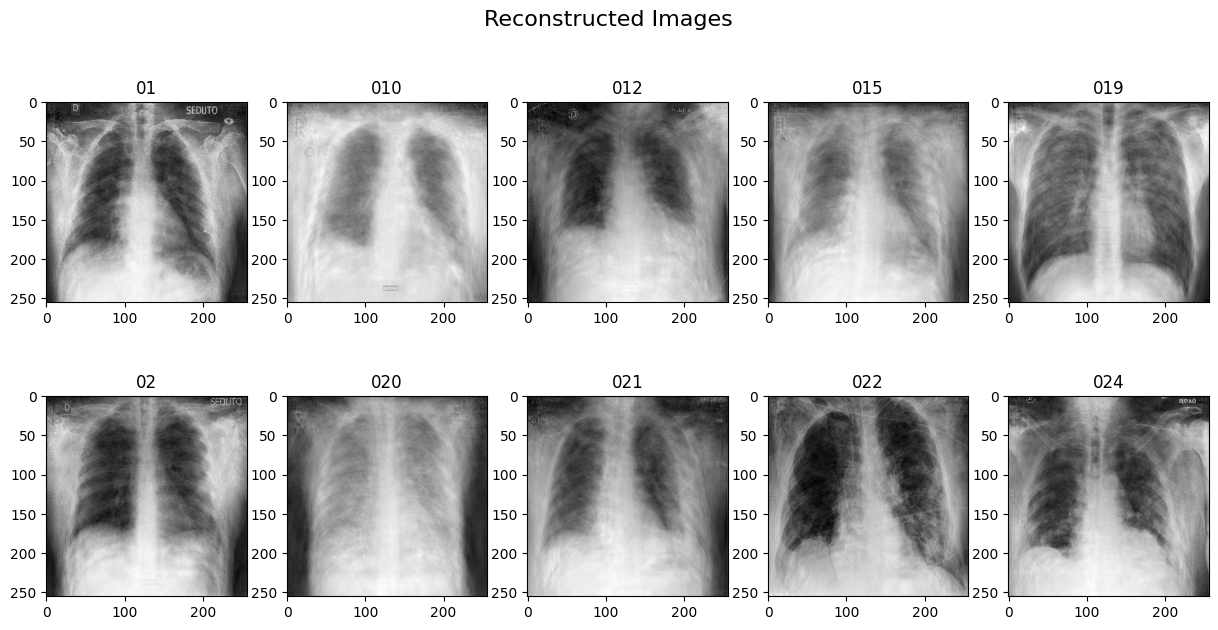

In [20]:
# reconstructed images after keeping 95 percent variance using PCA
plt.figure(figsize=(15, 7))
plt.suptitle("Reconstructed Images", fontsize=16)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pca_recovered[i], cmap='gray')
    if i < len(imgs):
        plt.title(imgs[i].removesuffix('.jpeg').removesuffix('.jpg').removesuffix('.png'))

# 3A:

In [21]:
pca_2 = PCA(n_components=2)
%time pca_reduced_2 = pca_2.fit_transform(img_flat)

CPU times: user 1.59 s, sys: 1.09 s, total: 2.68 s
Wall time: 1.45 s


In [22]:
print(f' The amount of variance explained by first two components is {sum(pca_2.explained_variance_ratio_) *100}%')

 The amount of variance explained by first two components is 36.353875549868555%


# 3A: Solution

 The amount of variance explained by first two components is 36.353875549868455%

# 3B:

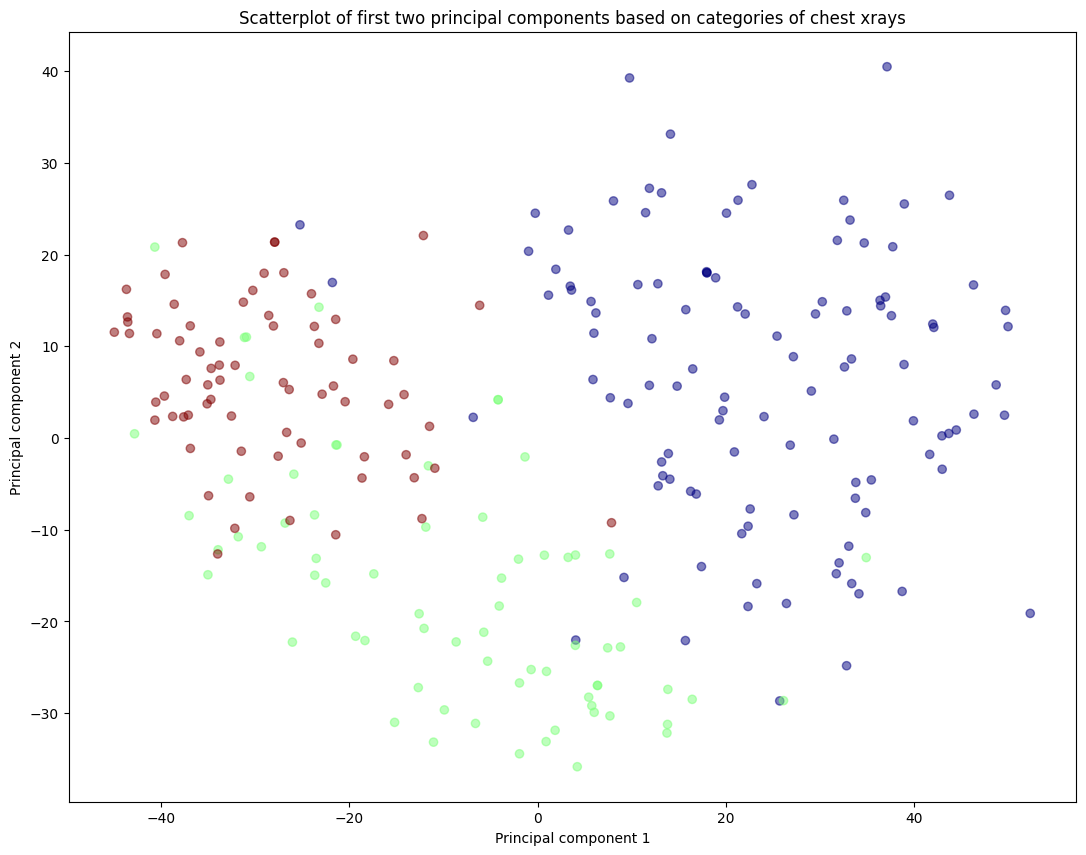

In [23]:
# scatterplot of first two principal components based on their categories
plt.figure(figsize=(13, 10))
plt.scatter(pca_reduced_2[:, 0], pca_reduced_2[:, 1],
           c=category,cmap="jet", alpha=0.5)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Scatterplot of first two principal components based on categories of chest xrays')
plt.show()

In [24]:
def plot_xrays(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    X_norm= MinMaxScaler().fit_transform(X)
    neighbors = np.array([[3., 3.]])

    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    categories = np.unique(y)
    plt.scatter(X_norm[:, 0], X_norm[:, 1],
           c=category,cmap="jet", alpha=0.5)

    ax = plt.gca()
    for idx, img_cord in enumerate(X_norm):
        closest_dist = np.linalg.norm(neighbors - img_cord, axis=1).min()
        if closest_dist > min_distance:
            neighbors = np.r_[neighbors, [img_cord]]
            if images is None:
                plt.text(img_cord[0], img_cord[1], str(int(y[idx])),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[idx].reshape(256, 256)
                imagebox = AnnotationBbox(OffsetImage(image,zoom = 0.03, cmap='binary'),
                                          img_cord)
                ax.add_artist(imagebox)

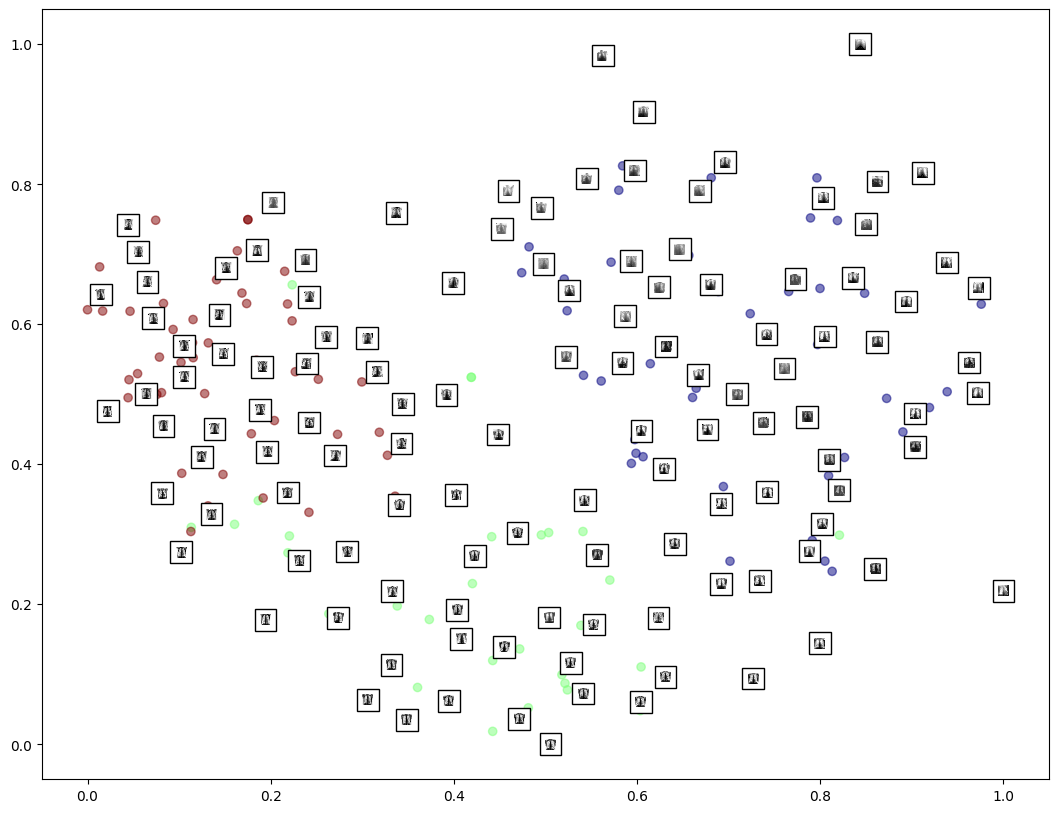

In [25]:
plot_xrays(X = pca_reduced_2,images = img_flat, y = category)

# T-SNE

In [26]:
tsne_2 = TSNE(n_components=2, learning_rate="auto", random_state=42)
%time tsne_reduced_2 = tsne_2.fit_transform(img_flat)

CPU times: user 6.42 s, sys: 804 ms, total: 7.22 s
Wall time: 5.93 s


In [27]:
tsne_reduced_2.shape

(251, 2)

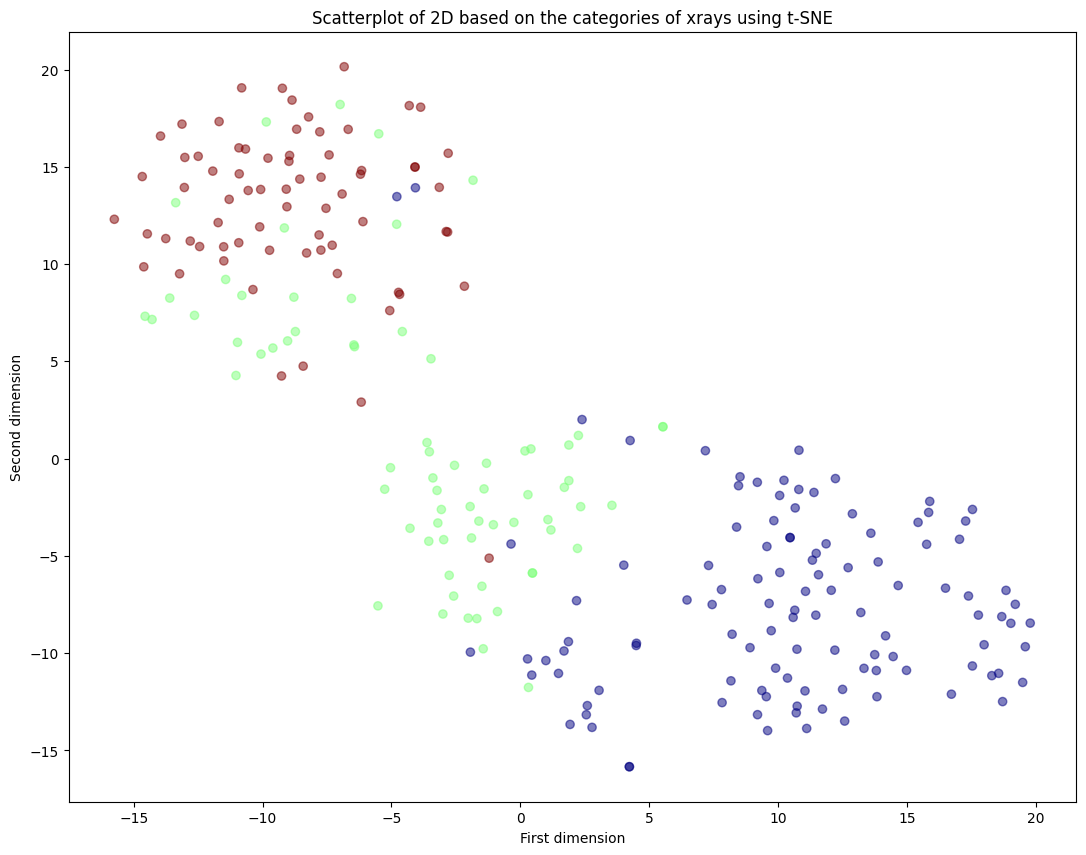

In [28]:
# Scatterplot of 2D based on the categories of xrays using t-SNE
plt.figure(figsize=(13, 10))
plt.scatter(tsne_reduced_2[:, 0], tsne_reduced_2[:, 1],
            c=category, cmap="jet", alpha=0.5)
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.title('Scatterplot of 2D based on the categories of xrays using t-SNE')
plt.show()

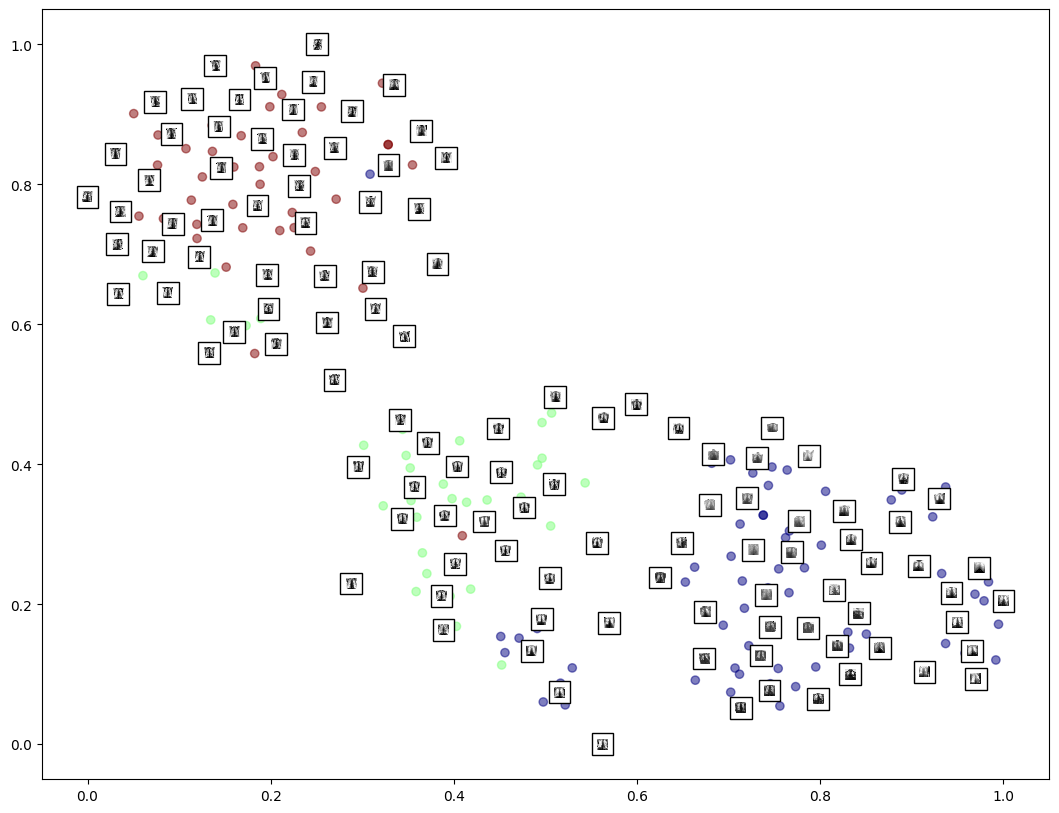

In [29]:
plot_xrays(X = tsne_reduced_2,images = img_flat, y = category)

# LLE

In [30]:
lle_2 = LocallyLinearEmbedding(n_components=2, random_state=42)
%time lle_reduced_2 = lle_2.fit_transform(img_flat)

CPU times: user 798 ms, sys: 156 ms, total: 955 ms
Wall time: 782 ms


In [31]:
lle_reduced_2.shape

(251, 2)

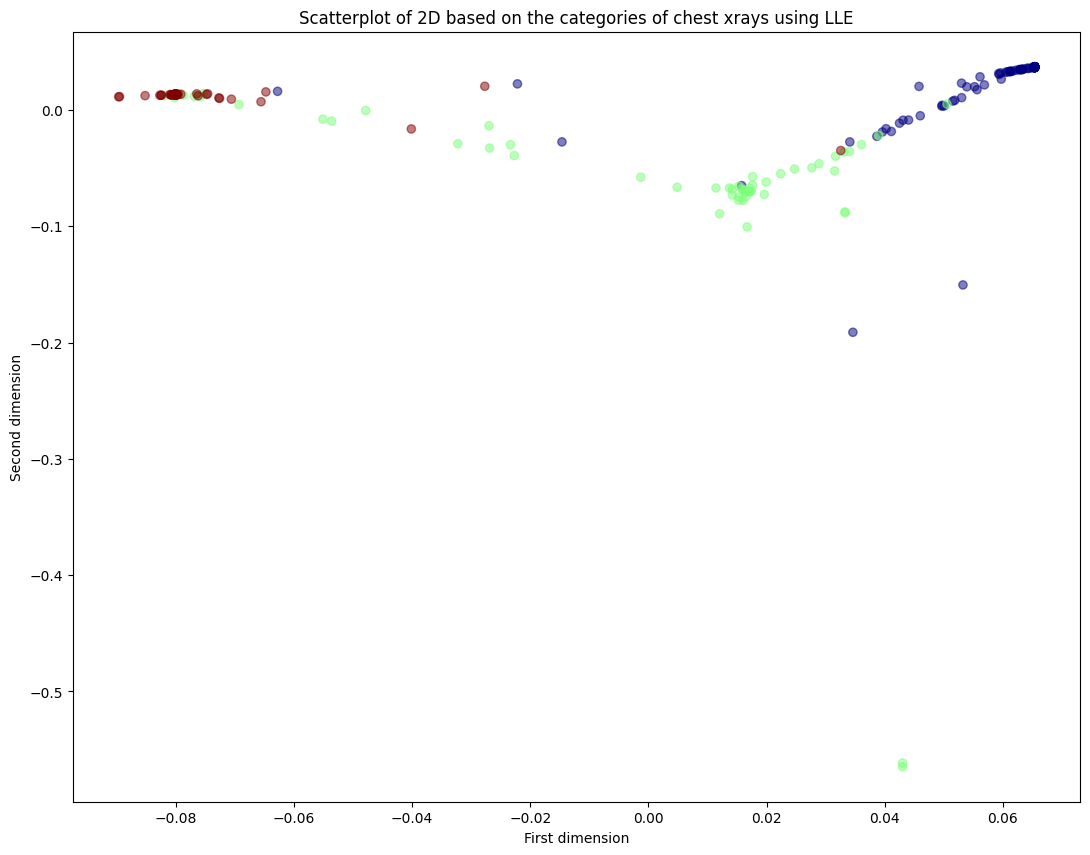

In [32]:
# Scatterplot of 2D based on the categories of xrays using LLE
plt.figure(figsize=(13, 10))
plt.scatter(lle_reduced_2[:, 0], lle_reduced_2[:, 1],
            c=category, cmap="jet", alpha=0.5)
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.title('Scatterplot of 2D based on the categories of chest xrays using LLE')
plt.show()

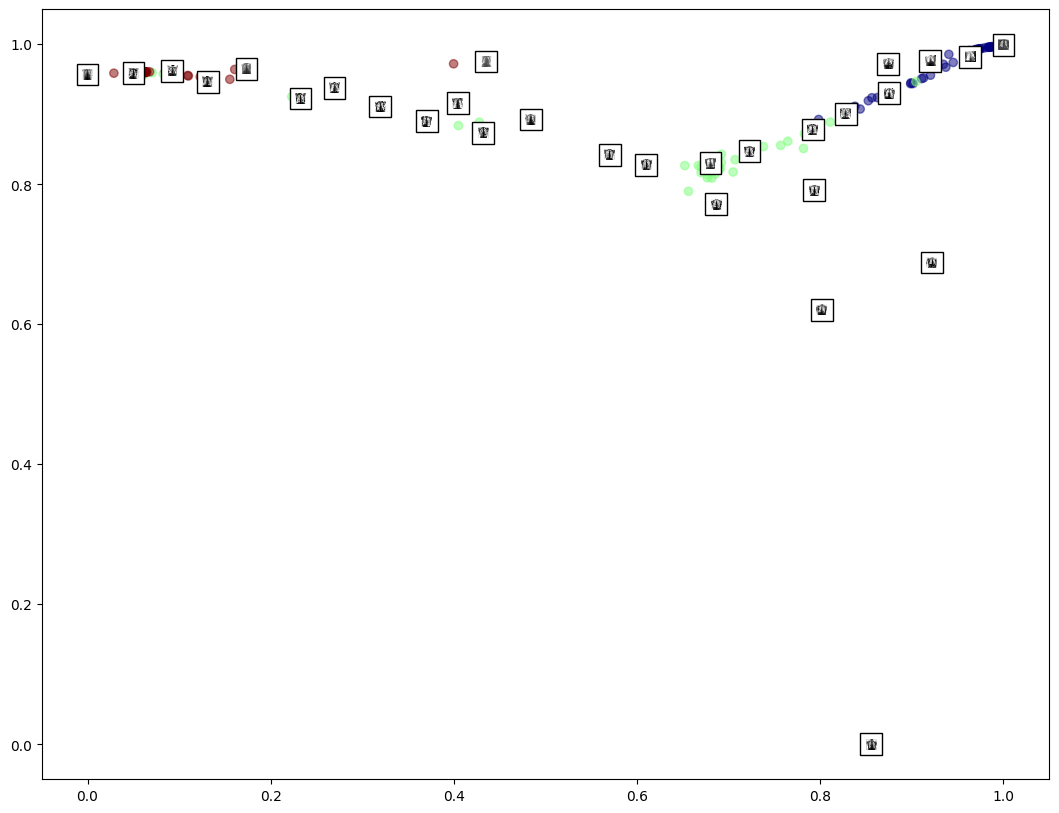

In [33]:
plot_xrays(X = lle_reduced_2,images = img_flat, y = category)

# MDS

In [34]:
mds_2 = MDS(n_components=2, random_state=42)
%time mds_reduced_2 = mds_2.fit_transform(img_flat)

CPU times: user 1.98 s, sys: 1.79 s, total: 3.77 s
Wall time: 2.75 s


In [35]:
mds_reduced_2.shape

(251, 2)

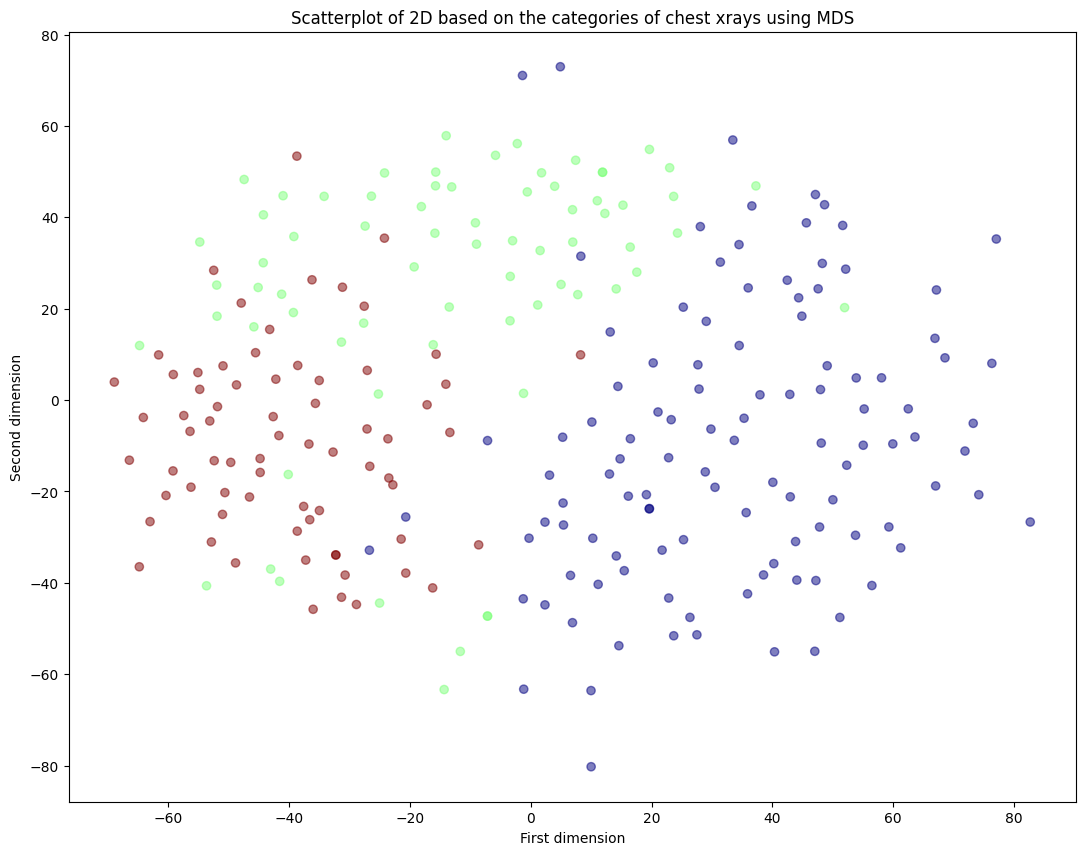

In [36]:
plt.figure(figsize=(13, 10))
plt.scatter(mds_reduced_2[:, 0], mds_reduced_2[:, 1],
            c=category, cmap="jet", alpha=0.5)
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.title('Scatterplot of 2D based on the categories of chest xrays using MDS')
plt.show()

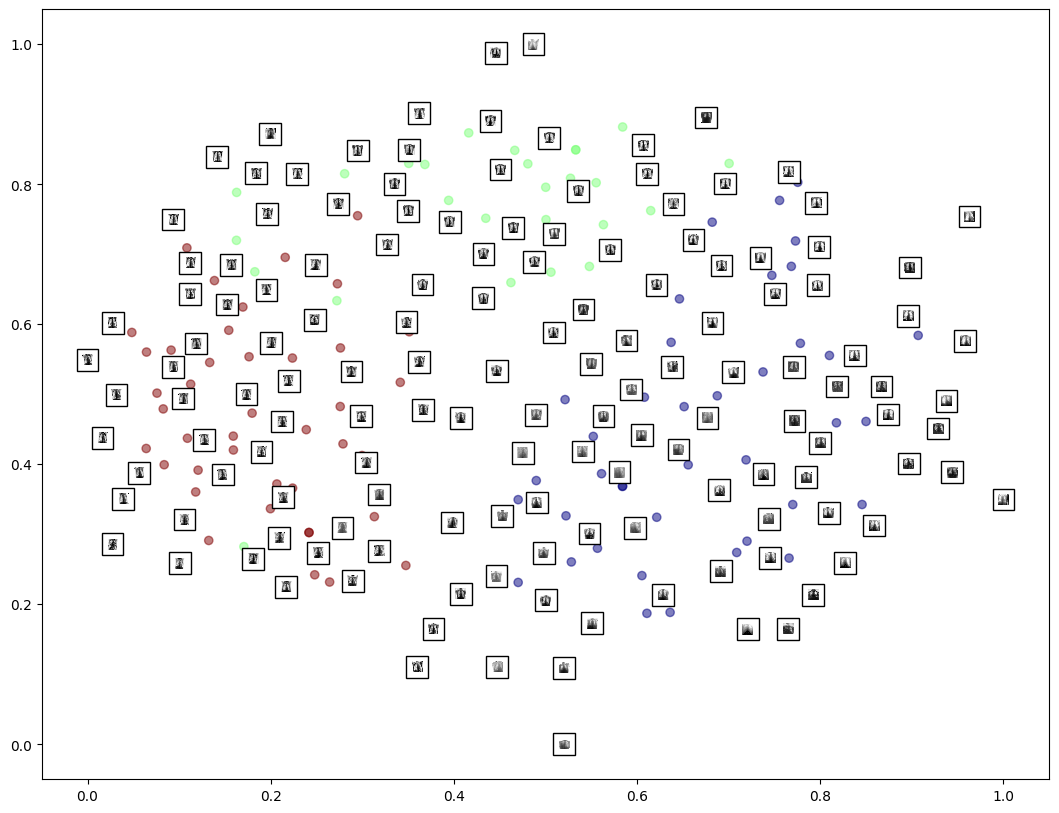

In [37]:
plot_xrays(X = mds_reduced_2,images = img_flat, y = category)

# 3C: Solution:

From the plots above, we can observe that PCA with only 2 componenets preserves about 36 percent of the  variance of the data and hence the categories are represneted and can be classified into 3 in 2D space - if we  increase the number of dimensions to be projected to lower dimensional space,PCA can capture more data but, it can get extremely difficult to plot and interpret such data with higher dimensions.

t-SNE is better than PCA as it forms more compact clusters when compared to PCA and categories are more well defined than PCA- where the categories are quite dispersed over the 2D space.

LLE, on the other hand performs worst for this data as it does not project the data well in lower dimensional space and produces cluttered visualization.

MDS also projects data similar to PCA -dispered into the 2D space, but it is much better than LLE.

Hence, for this data, t-SNE gives better visualization in lower dimsenional space as it forms compact and well bounded clusters when compared to other dimensionality reductuon methods.

PCA would have done better if it was using more than 2 components that preserves less variance and cannot capture the complex structure of the underlying data. Deep learning might give better results in classifying the data points for this dataset.

# 5:

# 5A:

We use silhouette score to identify the optimal number of clusters in the data.

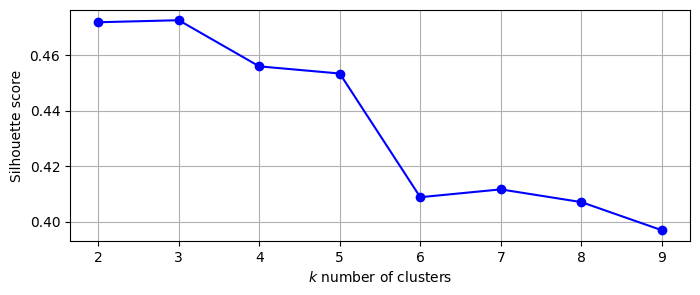

In [38]:
# silhouette scores plots to find optimal number of clusters k

kmeans = [KMeans(n_clusters=k, random_state=42).fit(pca_reduced_2)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(pca_reduced_2, model.labels_)
                     for model in kmeans[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$ number of clusters")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

Silhoutte score is highest for k= 3 number of clusters. That means that silhouette coefficient is higher(0.47 almost) - the instance is well inside its own cluster and far from other clusters. But it also underlines the fact that k= 2 is quite good as well with around 0.468.

When we plot silhouette diagram we can observe every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This can be used to verify either k=3 or 2 is the optimal number of clusters

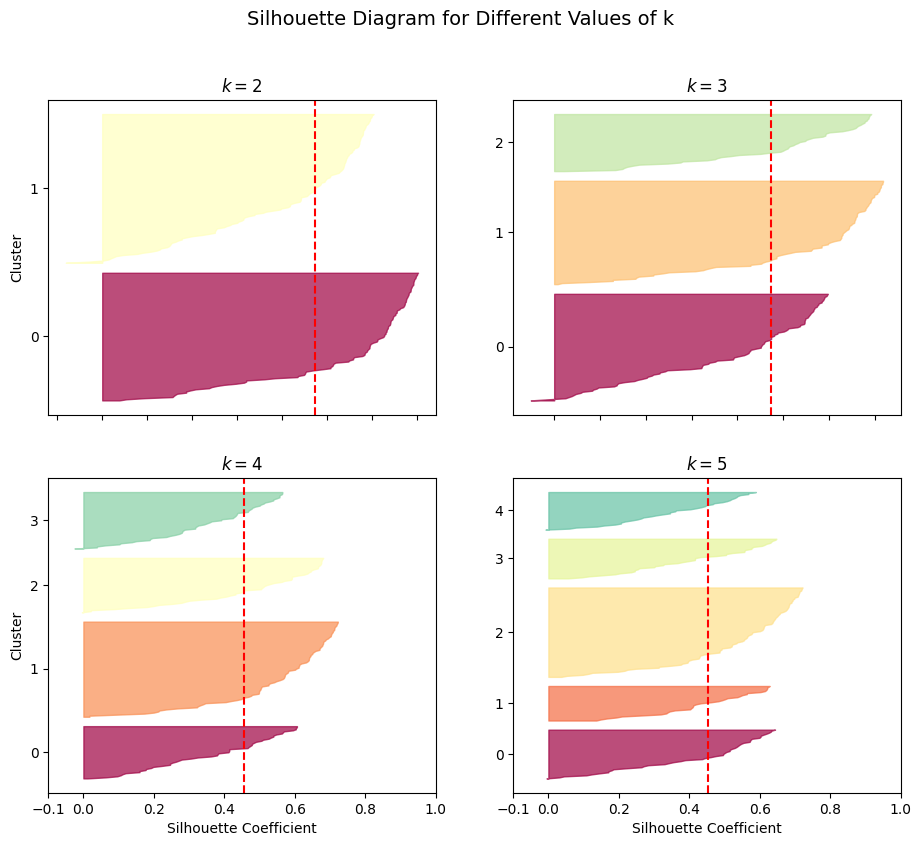

In [39]:
plt.figure(figsize=(11, 9))
plt.suptitle("Silhouette Diagram for Different Values of k", fontsize=14)

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)

    y_pred = kmeans[k - 1].labels_
    silhouette_coefficients = silhouette_samples(pca_reduced_2, y_pred)

    padding = len(pca_reduced_2) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")

    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

From the Silhoutte diagram we can observe that for k = 3, the clusters are equally spaced and have equal number of data points in each cluster when compared to k=2 which has two big cluster. So we take k=3 as it has equal values of data points in each cluster and higher silhouette score.

In [40]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_reduced_2)

KMeans(n_clusters=3, random_state=42)

# 5B:

In [41]:
def plot_decision_boundaries(clusterer, X, category, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    colours = {0: 'red', 1: 'green', 2: 'blue'}
    category_labels = {0: 'Covid', 1: 'Normal', 2: 'Viral Pneumonia'}

    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')

    j=0
    for i in np.unique(category):
      plt.plot(X[np.array(category)==i,0], X[np.array(category)==i,1], 'k.', markersize=7,c=colours[j], label=category_labels[i])
      j+=1
    if show_centroids:
      plt.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1],marker='o', s=35, linewidths=8, color='w', zorder=10, alpha=0.9)
      plt.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1],marker='x', s=2, linewidths=12, color='k', zorder=11, alpha=1)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.legend()
    plt.show()

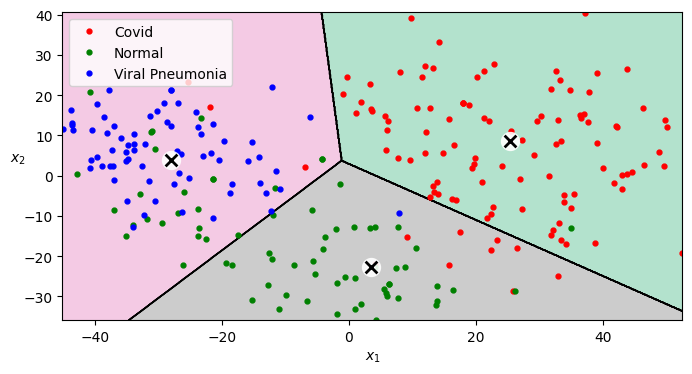

In [42]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, pca_reduced_2,category)
plt.show()

The clusters formed are almost compact and it classifies the data well. The centroids of the cluster are rightly placed in each of the categories even though there are few misclassification of data points of green and blue data points(Normal and viral pneumonia), but covid xrays have almost well defined boundaries

# 6:

# 6A:

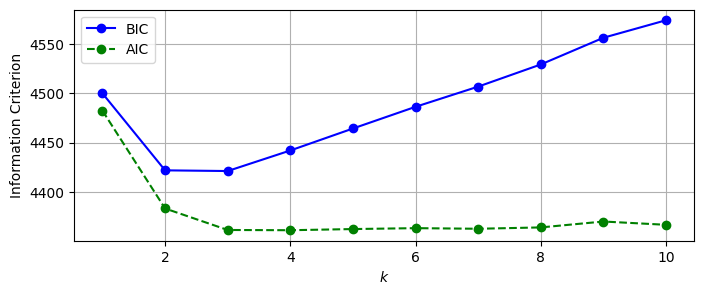

In [43]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(pca_reduced_2)
             for k in range(1, 11)]
bics = [model.bic(pca_reduced_2) for model in gms_per_k]
aics = [model.aic(pca_reduced_2) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.legend()
plt.grid()
plt.show()

The AIC and BIC scores are closer when k= 3 and 2. We can also cluster based on using Bayesian Gaussian Mixture class which is capable of giving weights equal (or close) to zero to unnecessary clusters.By setting the number of components to higher values, say 10, the algorithm will eliminate the unnecessary clusters automatically.

In [44]:
# used 10 componenets, but it automatically eliminates others and keeps 3
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(pca_reduced_2)
bgm.weights_.round(2)

array([0.  , 0.44, 0.37, 0.19, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

So in this case, we use 3 clusters for clustering with EM clustering on our dataset

# 6: B

In [45]:
gm = GaussianMixture(n_components=3, random_state=42,init_params ='k-means++', covariance_type="diag")
gm.fit(pca_reduced_2)

GaussianMixture(covariance_type='diag', init_params='k-means++', n_components=3,
                random_state=42)

In [46]:
gm.weights_

array([0.45795534, 0.34768003, 0.19436463])

In [47]:
gm.converged_

True

In [48]:
gm.n_iter_

6

In [49]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):

    colours = {0: 'red', 1: 'yellow', 2: 'blue'}
    category_labels = {0: 'Covid', 1: 'Normal', 2: 'Viral Pneumonia'}

    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    j=0
    for i in np.unique(category):
      plt.plot(X[np.array(category)==i,0], X[np.array(category)==i,1], 'k.', markersize=7,c=colours[j], label=category_labels[i])
      j+=1

    if clusterer.weights_ is not None:
      clusterer.means_ = clusterer.means_[clusterer.weights_ > clusterer.weights_.max() / 10]
    plt.scatter(clusterer.means_[:, 0], clusterer.means_[:, 1],marker='o', s=35, linewidths=8,color='w', zorder=10, alpha=0.9)
    plt.scatter(clusterer.means_[:, 0], clusterer.means_[:, 1],marker='x', s=2, linewidths=12, color='k', zorder=11, alpha=1)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

    plt.legend()
    plt.show()

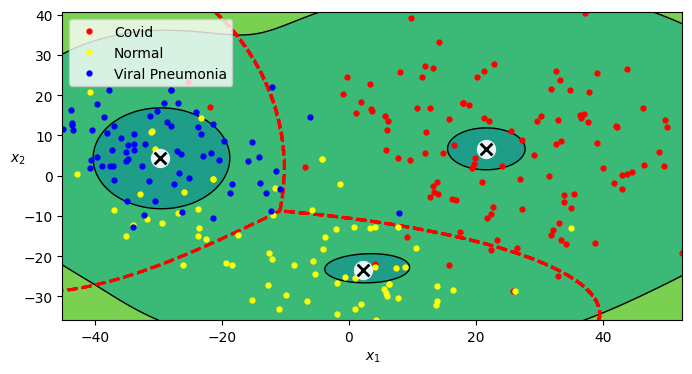

In [50]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, pca_reduced_2)
plt.show()

The resulting contour plot is similar to Kmeans, but we can observe few contours around the centriod of the clusters indicating the EM algorithm has tried to form compact clusters. There are a few data points normal (yellow) in viral pneumonia(blue) clusters which are misclassified. The Covid 19 cluster is well defined and bounded.

# 6:C

In [51]:
pca_2_new, y = gm.sample(20)
pca_2_new.shape

(20, 2)

In [52]:
pca_2_new_recovered = pca_2.inverse_transform(pca_2_new)

In [53]:
pca_2_new_recovered.shape

(20, 65536)

In [54]:
# reshaping to plot them
pca_2_new_recovered = pca_2_new_recovered.reshape(pca_2_new_recovered.shape[0], 256, 256)

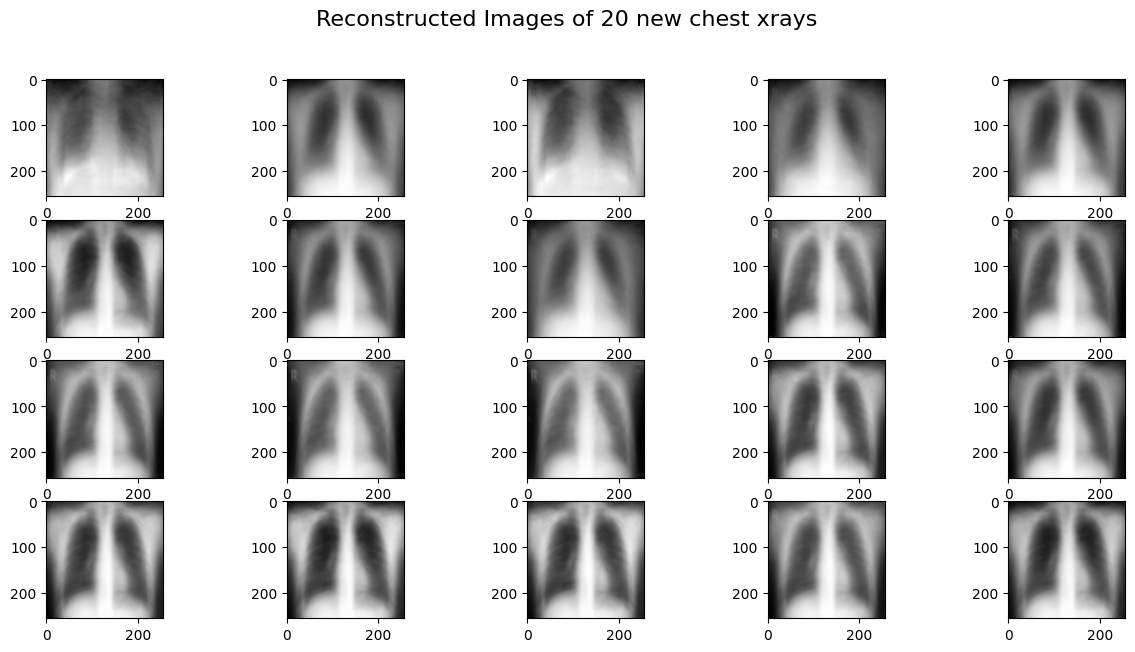

In [55]:
plt.figure(figsize=(15, 7))
plt.suptitle("Reconstructed Images of 20 new chest xrays", fontsize=16)
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pca_2_new_recovered[i], cmap='gray')

The reconstructed images looks blurred as this is PCA reconstructed data and not the original dataset images and hence it is reconstructed using only 36 percent variance captured by the PCA - only 2 components.

# 7:

In [56]:
path_covid_t = '/content/drive/MyDrive/AML/Covid19-dataset/test/Covid'
path_norm_t = '/content/drive/MyDrive/AML/Covid19-dataset/test/Normal'
path_viral_t= '/content/drive/MyDrive/AML/Covid19-dataset/test/Viral Pneumonia'

imgs_covid_t = sorted(os.listdir(path_covid_t))
imgs_norm_t = sorted(os.listdir(path_norm_t))
imgs_viral_t = sorted(os.listdir(path_viral_t))


img_covid_t=[]
y_covid_t =[]
for image in imgs_covid_t:
  img_covid_t.append(cv.imread(os.path.join(path_covid_t, image), cv.IMREAD_GRAYSCALE))
  y_covid_t.append(0)

y_norm_t =[]
img_norm_t= []
for image in imgs_norm_t:
  img_norm_t.append(cv.imread(os.path.join(path_norm_t, image), cv.IMREAD_GRAYSCALE))
  y_norm_t.append(1)

img_viral_t = []
y_viral_t =[]
for image in imgs_viral_t:
  img_viral_t.append(cv.imread(os.path.join(path_viral_t, image), cv.IMREAD_GRAYSCALE))
  y_viral_t.append(2)

imgs_t = imgs_covid_t + imgs_norm_t  + imgs_viral_t
img_t = img_covid_t + img_norm_t  + img_viral_t
category_t = y_covid_t + y_norm_t +y_viral_t

In [57]:
img_resized_t = []
for res_img in img_t:
  img_resized_t.append(cv.resize(res_img, (256, 256)))

# flatten
img_flat_t = []
for i in range(len(img_resized_t)):
  img_flat_t.append(np.ravel(img_resized_t[i]))
img_flat_t = np.array(img_flat_t)

# scaling
img_flat_t = img_flat_t/255.0

In [58]:
img_flat_t.shape

(66, 65536)

In [59]:
X_train = img_flat
y_train= np.array(category)
X_val= img_flat_t
y_val= np.array(category_t)

In [60]:
X_train = np.reshape(X_train, (len(X_train),256,256,1))
X_val = np.reshape(X_val, (len(X_val),256,256,1))

# 7A:

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

start_time = time.time()

model = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256,256,1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu',),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),shuffle=True, batch_size=32)

end_time = time.time()
training_time = end_time - start_time
print(f'Training time: {training_time}')

Epoch 1/100
8/8 [==============================] - 2s 86ms/step - loss: 24.3013 - accuracy: 0.4542 - val_loss: 0.9144 - val_accuracy: 0.5909
Epoch 2/100
8/8 [==============================] - 0s 37ms/step - loss: 0.8983 - accuracy: 0.6972 - val_loss: 0.8053 - val_accuracy: 0.5758
Epoch 3/100
8/8 [==============================] - 0s 41ms/step - loss: 0.5584 - accuracy: 0.7849 - val_loss: 0.8030 - val_accuracy: 0.6818
Epoch 4/100
8/8 [==============================] - 0s 40ms/step - loss: 0.4710 - accuracy: 0.8167 - val_loss: 0.4864 - val_accuracy: 0.7727
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 0.3897 - accuracy: 0.8645 - val_loss: 0.5586 - val_accuracy: 0.7576
Epoch 6/100
8/8 [==============================] - 0s 42ms/step - loss: 0.8440 - accuracy: 0.8446 - val_loss: 0.3818 - val_accuracy: 0.8182
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 0.4112 - accuracy: 0.8406 - val_loss: 0.5537 - val_accuracy: 0.7576
Epoch 8/100
8/8 [==

# 7A: Solution
The training time reported is 33.08822512626648 ms



# 7B:

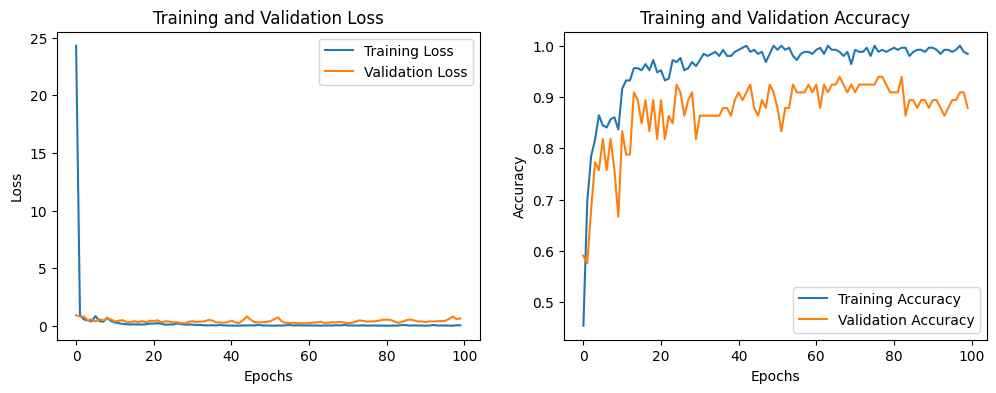

In [69]:
#training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

# 7B: Solution:
From the training and validation loss plot, we observe that the training loss keeps decreasing rapidly while the validation loss almost remains the same 100 epochs. From the training and validation accuracy plot, we see that training and validation accuracy increases throughout the epochs and reaches around training accuracy of 98.41 percent and validation accuracy 87.88 percent which is pretty good for this dataset. Maybe if we increase the value of the training data by augmentatation, we can acheive higher accuracies and also introduce random new data samples into our original data.

# 7C:

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 123008)            0         
                                                                 
 dense_8 (Dense)             (None, 64)               

# 7C: Solution:


The total number of parameters of the network are 7877571. Of those 115 parameters are bias parameters.

# References:

1. Dataset - https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/data
2. Textbook- https://github.com/ageron/handson-ml3/tree/main
3. https://www.dataknowsall.com/imagepca.html#:~:text=PCA%20is%20nicely%20demonstrated%20when,array%20and%20see%20its%20shape.